In [1]:
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ehrapy as ep
import numpy as np
import cellrank as cr
from cellrank.tl.kernels import ConnectivityKernel
from cellrank.tl.kernels import PseudotimeKernel
import scvelo as scv
import dill
import scanpy as sc

Unable to contact PyPI to check for the latest ehrapy version. Do you have an internet connection?

In [2]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [ ]:
#save the session
dill.dump_session('EHRAPY_Trajectories_Recovered_ED_LD.db')

In [3]:
#load the session
dill.load_session('EHRAPY_Trajectories_Recovered_ED_LD.db')

# 1- Dataset preparation

In [ ]:
#Read in the data
# missing data was imputed with the missMDA package with the imputeMFA function
df = pd.read_csv('./COVID_Clinical_Luminex_deceased_recovered_EHRAPY.csv') #data is not scaled 


In [ ]:
df

In [ ]:
adata = ep.ad.df_to_anndata(
    df, index_column="RecordID", columns_obs_only=["Category", "Category2","Day_of_Sampling", "Average_DOS"]
)

In [ ]:
adata

In [ ]:
adata.obs

In [ ]:
# The AnnData object also has data in the uns (unstructured) slot which denotes which columns are numerical columns and which ones aren’t.
# This may be required for specific algorithms.
adata.uns

In [ ]:
# Finally, the layers slot of our object saves all original values when the object was created. 
# We will constantly modify our X when applying algorithms to our object (e.g. scaling) and this layer is a copy of our original X 
# which will allow us to e.g. scale the age, but use the original values when coloring a UMAP plot.


adata.layers["original"]

In [ ]:
ep.ad.type_overview(adata)

# 2- Preprocessing

Quality control - missing values

In [ ]:
# ehrapy’s qc_metrics function will calculate several useful metrics such as
# the absolute number and percentages of missing values and properties like the mean/median/min/max of all features.

_ = ep.pp.qc_metrics(adata)
ep.pl.qc_metrics(adata)

In [ ]:
adata.obs

In [ ]:
_ = sns.displot(adata.obs["missing_values_abs"])
plt.show()

_ = sns.displot(adata.obs["missing_values_pct"])

Missing data imputation

In [ ]:
ep.pp.knn_impute(adata)

In [ ]:
# We can now confirm that there are indeed no missing values present.

_ = sns.displot(adata.obs["missing_values_abs"])
plt.show()

_ = sns.displot(adata.obs["missing_values_pct"])
plt.show()

_ = sns.displot(adata.var["missing_values_abs"])
plt.show()

_ = sns.displot(adata.var["missing_values_pct"])



Data Distribution

In [ ]:
# Depending on the measurement and the unit of a measurement the value ranges of features may be huge. 
# Clusterings and differential comparisons especially may be greatly influenced by exceptionally big values.

_ = sns.displot(adata.var["min"])
plt.show()

_ = sns.displot(adata.var["max"])
plt.show()

_ = sns.displot(adata.var["standard_deviation"])


In [ ]:
adata.var[adata.var["standard_deviation"] > 500]

In [ ]:
ep.pp.pca(adata)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.tl.leiden(adata, resolution=0.5, key_added="leiden_0_5")

In [ ]:
ep.tl.leiden(adata, resolution=1, key_added="leiden_1")

In [ ]:
ep.pl.umap(adata, color=["leiden_0_5"], title="Leiden 0.5")

In [ ]:
ep.pl.umap(adata, color=["leiden_1"], title="Leiden 1")

In [ ]:
ep.pl.umap(
    adata,
    color=["Category2", "Day_of_Sampling"],
    wspace=0.5,
    title=["Category2", "Day_of_Sampling"],
)

# 3- Normalization and dimensionalty reduction

Ehrapy offers several options to normalize data. While it is possible to normalize all numerical values at once with the same normalization function we might be able to get away with just normalizing per feature.

In [ ]:
# in the tutorial, the data was not normalised, but try here with normalised data
adata_norm = ep.pp.scale_norm(adata, copy=True)

In [ ]:
_ = ep.pp.qc_metrics(adata_norm)
ep.pl.qc_metrics

In [ ]:
ep.pp.pca(adata_norm)
ep.pp.neighbors(adata_norm)
ep.tl.umap(adata_norm)
ep.tl.leiden(adata_norm, resolution=0.5, key_added="leiden_0.5")

In [ ]:
ep.tl.leiden(adata_norm, resolution=1, key_added="leiden_1")

In [ ]:
ep.pl.umap(adata_norm, color=["leiden_0.5"], title="Leiden 0.5")

In [ ]:
ep.pl.umap(adata_norm, color=["leiden_1"], title="Leiden 1", save = "_Leiden_res1.pdf")

In [ ]:
#F08080 - light coral
#87CEFA - lightskyblue
#D3D3D3 - lightgrey

pretty_colors = ['#000066', '#D3D3D3']
pretty_colors2 = ['#FA8072','#92C7F9', '#D3D3D3']
color_pal = sns.color_palette(pretty_colors2)

In [ ]:
ep.pl.umap(
    adata_norm,
    wspace=0.3,color=["Category"], palette = pretty_colors,
    title=["COVID-19 outcome"], save = "_outcome.pdf"
)

In [ ]:
ep.pl.umap(
    adata_norm,
    color=["Category2"], palette = pretty_colors2,
    wspace=0.3,
    title=["COVID-19 progression"], save = "_progression.pdf",
)

In [ ]:
ep.pl.umap(
    adata_norm,
    color=["Day_of_Sampling"],
    wspace=0.3, 
    title=["Day of Sampling"],
)

# 4- Determining patient fate using a ConnectivityKernel

Depending on the data it may not always be possible to clearly define a cluster or specific patients as the origin. When working with single-cell data this is easier because when stem cells are detected these are usually the origin of cell differentiation processes.

In our case we do not have any clear origin and will therefore start with cellrank’s ConnectivityKernel. This kernel computes transition probabilities based on similarities among patients using a KNN graph.
First we define the kernel, compute the transition matrix and a projection ontop of the UMAP.

In [ ]:
# Based on the non-normalised data
ck = ConnectivityKernel(adata)
ck.compute_transition_matrix()
ck.compute_projection(basis="umap")

Note that ConnectivityKernel has a backward parameter which can be set to True to compute everything backwards in time.

We can now visualize the project forwards and backwards in time using scvelo.

In [ ]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_0_5")

In [ ]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="leiden_1")

In [ ]:
ep.pl.umap(adata, color="Category", title="Recovery vs Fatal")

In [ ]:
# Using the normalised data
ck2 = ConnectivityKernel(adata_norm)
ck2.compute_transition_matrix()
ck2.compute_projection(basis="umap")

In [ ]:
scv.pl.velocity_embedding_stream(adata_norm, vkey="T_fwd", basis="umap", color="leiden_0_5")

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_trajectories.png


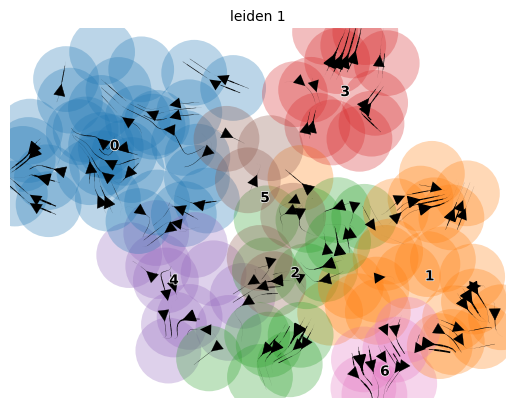

In [9]:
scv.pl.velocity_embedding_stream(adata_norm, vkey="T_fwd", basis="umap", density=3, arrow_size = 2, color="leiden_1", save = "trajectories.pdf")

# 5- Determining macrostates and terminal states

Let’s try to find the origins of the “death clusters”. We will now define a GPCCA estimator to predict the patient fates using the above calculated transition matrix.

In [ ]:
# Based on non-norm data
g = cr.tl.estimators.GPCCA(ck)

In [ ]:
# As a first step we try to identify macrostates in the data.
g.compute_macrostates(n_states=3, cluster_key="leiden_0_5")
g.macrostates_memberships

In [ ]:
g.compute_macrostates(n_states=3, cluster_key="leiden_1")
g.macrostates_memberships

In [ ]:
g.plot_macrostates()
g.plot_macrostates(discrete=True)

In [ ]:
g.plot_macrostates(same_plot=False, ncols=2)

In [ ]:
# define the macrostates as our terminal states.
g.set_terminal_states_from_macrostates(["1", "3"])
g.plot_terminal_states()

In [ ]:
# Based on norm data
g2 = cr.tl.estimators.GPCCA(ck2)

In [ ]:
# As a first step we try to identify macrostates in the data.
g2.compute_macrostates(n_states=3, cluster_key="leiden_0_5")
g2.macrostates_memberships

In [ ]:
g2.compute_macrostates(n_states=3, cluster_key="leiden_1")
g2.macrostates_memberships

In [ ]:
g2.plot_macrostates()
g2.plot_macrostates(discrete=True)

In [ ]:
g2.plot_macrostates(same_plot=False, ncols=2)

In [ ]:
# define the macrostates as our terminal states.
g2.set_terminal_states_from_macrostates(["0","1","3"])
g2.plot_terminal_states()

# 6- Calculating absorption probabilities

For each visit, this computes the probability of being absorbed in any of the terminal_states. In particular, this corresponds to the probability that a random walk initialized in transient visit will reach any visit from a fixed transient state before reaching a visit from any other transient state.

In [ ]:
g2.compute_absorption_probabilities()

In [ ]:
g2.plot_absorption_probabilities()

In [ ]:
# We can also calculate a pseudotime which is required for all patient visits to reach these states.
g2.compute_absorption_probabilities(time_to_absorption="all")
g2.absorption_times


In [ ]:
adata_norm.obs["mean_time_to_absorption"] = g2.absorption_times["0, 1, 3 mean"]
scv.pl.scatter(adata_norm, color="mean_time_to_absorption")

# 7- Extracting lineage drivers

As a next step we want to determine the major features driving these transitions and terminal states.


In [ ]:
g2.compute_lineage_drivers()

In [ ]:
g2.plot_lineage_drivers(lineage="0", ncols=2, save = ".pdf")

In [ ]:
g2.plot_lineage_drivers(lineage="1", ncols=2)

In [ ]:
g2.plot_lineage_drivers(lineage="3", ncols=2)

# 8- Exploring cluster fates

In [ ]:
cr.pl.cluster_fates(adata_norm, mode="bar", cluster_key="leiden_1")

In [ ]:
cr.pl.cluster_fates(adata_norm, mode="heatmap", cluster_key="leiden_1")
cr.pl.cluster_fates(adata_norm, mode="clustermap", cluster_key="leiden_1")

We can also leverage PAGA to visualize this information in a PAGA graph

In [ ]:
ep.tl.paga(adata_norm, groups="leiden_1")

In [ ]:
cr.pl.cluster_fates(adata_norm, mode="paga_pie", basis="umap", cluster_key="leiden_1")

In [ ]:
cr.pl.cluster_fates(
    adata_norm, mode="paga", legend_loc="on data", basis="umap", cluster_key="leiden_1"
)

In [ ]:
cr.pl.circular_projection(
    adata_norm, keys=["leiden_1", "kl_divergence"], legend_loc="upper right"
)

# 9- Determining patient fate with a PseudotimeKernel

• We have now learnt that for example death dominated cluster 7 origins from cluster 10 (high IV). Hence, we will now set a patient from cluster 10 as our root for our pseudotime calculation and will verify that we would indeed end up in clusters 4, 7 and 8.
• Using pseudotime to find terminal states is even more useful when the terminal states are unknown and only a root cluster is clear.
• The Pseudotime kernel computes direct transition probabilities based on a KNN graph and pseudotime.
• The KNN graph contains information about the (undirected) connectivities among cells, reflecting their similarity. Pseudotime can be used to either remove edges that point against the direction of increasing pseudotime, or to downweight them.

In [ ]:
adata_norm.uns["iroot"] = np.flatnonzero(adata_norm.obs["leiden_1"] == "5")[0]
ep.tl.dpt(adata_norm)

In [ ]:
pk = PseudotimeKernel(adata_norm)
pk.compute_transition_matrix()
pk.compute_projection(basis="umap")

In [ ]:
scv.pl.velocity_embedding_stream(adata_norm, vkey="T_fwd", basis="umap", color="leiden_1")

# 10- Simulating transitions with random walks

Cellrank makes it easy to simulate the behavior of random walks from specific clusters. This allows us to not only visualize where the patients end up, but also roughly how many in which clusters after a defined number of iterations. We can either just start walking…

In [ ]:
pk.plot_random_walks(
    100,
    start_ixs={"leiden_1": "0"},
    max_iter=100,
    show_progress_bar=False,
    ixs_legend_loc="best",
    seed=42,
)

In [ ]:
# … or set a number of required hits in one or more terminal clusters. Here, we require 50 hits in one of our three “death” clusters.
pk.plot_random_walks(
    200,
    start_ixs={"leiden_1": "1"},
    stop_ixs={"leiden_1": ["0", "3", "6"]},
    max_iter=100,
    successive_hits=50,
    show_progress_bar=False,
    cmap="viridis",
    seed=42,
)

# 11- Determining feature trends

cellrank uses Generalized Additive Models (GAMs) to determine trends of features.

In [ ]:
model = cr.ul.models.GAM(adata_norm)
cr.pl.gene_trends(
    adata_norm,
    model,
    ["TPO"],
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)

In [ ]:
cr.pl.gene_trends(
    adata,
    model,
    ["iv_day_1"],
    same_plot=True,
    hide_cells=True,
    time_key="dpt_pseudotime",
    show_progress_bar=False,
)